# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from botorch.exceptions import InputDataWarning
from linear_operator.utils.warnings import NumericalWarning
import warnings
warnings.simplefilter("ignore", (UserWarning, InputDataWarning, NumericalWarning))

from baybe import Campaign
from baybe.objectives import SingleTargetObjective
from baybe.parameters import (
    CategoricalParameter,
    NumericalDiscreteParameter,
    SubstanceParameter,
)
from baybe.recommenders import RandomRecommender
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget
from utils import backtest_plot

# Settings

In [45]:
N_DOE_ITERATIONS = 40
N_MC_ITERATIONS = 100
BATCH_SIZE = 1

lookup = pd.read_csv("../data/direct_arylation.csv")

dict_solvent = {
    "DMAc": r"CC(N(C)C)=O",
    "Butyornitrile": r"CCCC#N",
    "Butyl Ester": r"CCCCOC(C)=O",
    "p-Xylene": r"CC1=CC=C(C)C=C1",
}
dict_base = {
    "Potassium acetate": r"O=C([O-])C.[K+]",
    "Potassium pivalate": r"O=C([O-])C(C)(C)C.[K+]",
    "Cesium acetate": r"O=C([O-])C.[Cs+]",
    "Cesium pivalate": r"O=C([O-])C(C)(C)C.[Cs+]",
}
dict_ligand = {
    "BrettPhos": r"CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)="
    "CC=C2OC",
    "Di-tert-butylphenylphosphine": r"CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C",
    "(t-Bu)PhCPhos": r"CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3",
    "Tricyclohexylphosphine": r"P(C1CCCCC1)(C2CCCCC2)C3CCCCC3",
    "PPh3": r"P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3",
    "XPhos": r"CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C",
    "P(2-furyl)3": r"P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3",
    "Methyldiphenylphosphine": r"CP(C1=CC=CC=C1)C2=CC=CC=C2",
    "1268824-69-6": r"CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C",
    "JackiePhos": r"FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C(OC)=CC=C2OC)"
    r"C4=CC(C(F)(F)F)=CC(C(F)(F)F)=C4)=CC(C(F)(F)F)=C1",
    "SCHEMBL15068049": r"C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1",
    "Me2PPh": r"CP(C)C1=CC=CC=C1",
}

# BayBE Setup

In [46]:
objective = SingleTargetObjective(target=NumericalTarget(name="yield", mode="MAX"))

substance_encodings = ["MORDRED", "RDKIT", "MORGAN_FP"]
scenarios = {
    encoding: Campaign(
        searchspace=SearchSpace.from_product(
            parameters=[
                SubstanceParameter(name="Solvent", data=dict_solvent, encoding=encoding),
                SubstanceParameter(name="Base", data=dict_base, encoding=encoding),
                SubstanceParameter(name="Ligand", data=dict_ligand, encoding=encoding),
                NumericalDiscreteParameter(name="Temp_C", values=[90, 105, 120]),
                NumericalDiscreteParameter(name="Concentration", values=[0.057, 0.1, 0.153]),
            ]
        ),
        objective=objective,
    )
    for encoding in substance_encodings
}

In [47]:
parameters = [
    CategoricalParameter(name="Solvent", values=dict_solvent.keys(), encoding="OHE"),
    CategoricalParameter(name="Base", values=dict_base.keys(), encoding="OHE"),
    CategoricalParameter(name="Ligand", values=dict_ligand.keys(), encoding="OHE"),
    NumericalDiscreteParameter(name="Temp_C", values=[90, 105, 120], tolerance=2),
    NumericalDiscreteParameter(name="Concentration", values=[0.057, 0.1, 0.153]),
]

campaign_ohe = Campaign(
    searchspace=SearchSpace.from_product(parameters=parameters),
    objective=objective,
)

campaign_rand = Campaign(
    searchspace=SearchSpace.from_product(parameters=parameters),
    recommender=RandomRecommender(),
    objective=objective,
)

scenarios.update({"OneHot": campaign_ohe, "Random Baseline": campaign_rand})

# Backtest

In [49]:
results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

results.rename(columns={"Scenario": "Substance encoding", 
                        "Num_Experiments": "Number of experiments",
                        "yield_CumBest": "Best cumulative yield"}, inplace=True)

100%|###########################################################################################################################################################################| 500/500 [11:57<00:00,  1.44s/it]


# Store Results

In [50]:
results.to_csv('../results/chemical_encodings.csv', index=None)

# Load Result

In [2]:
results = pd.read_csv('../results/chemical_encodings.csv')

# Visualization

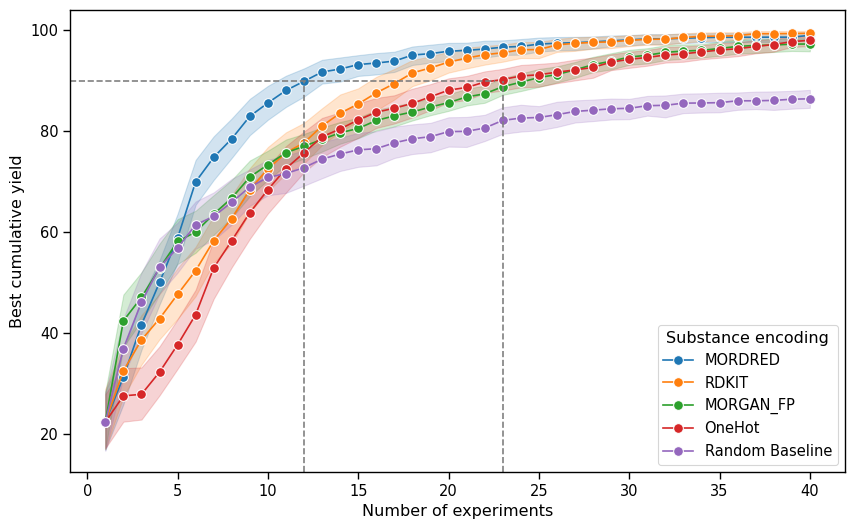

In [3]:
backtest_plot(df = results, 
              figure_name='chemical_encodings',  
              x='Number of experiments', y='Best cumulative yield', hue='Substance encoding', 
              indicator_y=90, 
              indicator_labels=['MORDRED','OneHot']
             )